In [89]:
#importing all libraries
import math
import random

import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx

from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram

#the verbosity variable used for debug
# set to 1 for basic or 2 for more detail
verbosity=1
my_account_key='insert your account key here'


In [90]:
#linear rescaling and logistics functions
# to handle large numbers in a linear/non-linear way respectively

k_c=1
k_s=4

def linear_rescale(x,x_min,x_max):
    return (x-x_min)/(x_max-x_min)

def logistic(x,k_x):
    return 1.0/(1.0+math.exp(-k_x*x))


In [91]:
#the cities we have under consideration
#to add cities, just extend the array
#and if the city you add has extreme values for 
#parameters of interest, update teh ranges below

cities = ['tokyo',\
          'beijing',\
          'london',\
          'new york city',\
          'washington dc',
          'los angeles',\
          'mumbai']
          #'delhi',\
          #'abu dhabi',\
          #'bangladesh',\
          #'cape town']
          #'sydney',
          #'moscow',
          #'st peterburg',
          #'miami'
        

#parameters of interest for each city
#to add a new parameter, simply extend the array
#when adding a new city you must consider
#whether it affects these upper/lower limits

params={
        'population':[5000000,20000000],\
        'population over 50':[1000000,50000000],\
        'population over 70':[500000,1000000],\
        'active covid cases':[10,1000000], \
        'commercial transportation':[1000,1000000],\
        'freight transportation':[1000,1000000],\
        'total jobs':[2000000,5000000],\
        'growth industries':[0,100],\
        'medical freight':[100,100000],\
        'vaccine inventory':[1000,10000000],\
        'vaccinated population':[1000,5000000]
}

def get_param_value(param):
    min_value = params[param][0]
    max_value = params[param][1]
    return random.randint(min_value,max_value)

cities_params={}
for city in cities:
    city_params_temp={}
    for param in params:
        city_params_temp[param]=get_param_value(param)
        #max_values.append(param,city_params_temp[param])
    cities_params[city]=city_params_temp



if verbosity==1:
    print(cities_params)
    
    
    

{'tokyo': {'population': 8722082, 'population over 50': 33874466, 'population over 70': 986807, 'active covid cases': 103177, 'commercial transportation': 837313, 'freight transportation': 373962, 'total jobs': 4084934, 'growth industries': 47, 'medical freight': 80123, 'vaccine inventory': 2977524, 'vaccinated population': 3049020}, 'beijing': {'population': 15895002, 'population over 50': 5376641, 'population over 70': 850579, 'active covid cases': 589619, 'commercial transportation': 597897, 'freight transportation': 848867, 'total jobs': 2892837, 'growth industries': 7, 'medical freight': 91420, 'vaccine inventory': 7420041, 'vaccinated population': 418814}, 'london': {'population': 17997671, 'population over 50': 47999726, 'population over 70': 610048, 'active covid cases': 141405, 'commercial transportation': 484132, 'freight transportation': 969408, 'total jobs': 3149452, 'growth industries': 53, 'medical freight': 94808, 'vaccine inventory': 8145668, 'vaccinated population': 29

In [92]:
#Assigning values to the four factors that affect covid and supply chains
#These are (for covid):
#         relative transmissibility 
#         mortality impact
#These are (for supply chains):
#         shipping disruption 
#         job loss
#these are NOT the only factors to consider, but are indicative
#the functional relationships are also not realistic, but indicative

connections_covid_factors={}
connections_supply_factors={}

#we will also need an array to keep track of the values
#because we will need the max values for scaling
TRAN_VALUES=[]
MORT_VALUES=[]
SHIP_VALUES=[]
JOBS_VALUES=[]

for i in range(len(cities)):
    for j in range(i+1,len(cities)):
        city_i_city_j_covid_factors={'relative transmissibility':
                                      1000*linear_rescale(cities_params[cities[i]]['population'],
                                                    params['population'][0],
                                                    params['population'][1])
                                      *linear_rescale(cities_params[cities[j]]['population'],
                                                    params['population'][0],
                                                    params['population'][1])
                                      *linear_rescale(cities_params[cities[i]]['active covid cases'],
                                                    params['population'][0],
                                                    params['population'][1])
                                      *linear_rescale(cities_params[cities[j]]['active covid cases'],
                                                    params['active covid cases'][0],
                                                    params['active covid cases'][1]),
                                     'mortality impact':
                                      1000*linear_rescale(cities_params[cities[i]]['population'],
                                                    params['population'][0],
                                                    params['population'][1])
                                      *linear_rescale(cities_params[cities[j]]['population'],
                                                    params['population'][0],
                                                    params['population'][1])
                                      *linear_rescale(cities_params[cities[i]]['population over 50'],
                                                    params['population over 50'][0],
                                                    params['population over 50'][1])
                                      *linear_rescale(cities_params[cities[j]]['population over 50'],
                                                    params['population over 50'][0],
                                                    params['population over 50'][1])
                                     }
        connections_covid_factors[cities[i]+"_"+cities[j]] = city_i_city_j_covid_factors
        TRAN_VALUES.append(city_i_city_j_covid_factors['relative transmissibility'])
        MORT_VALUES.append(city_i_city_j_covid_factors['mortality impact'])
        city_i_city_j_supply_factors={'shipping disruption':
                                      1000*linear_rescale(cities_params[cities[i]]['population'],
                                                    params['population'][0],
                                                    params['population'][1])
                                      *linear_rescale(cities_params[cities[j]]['population'],
                                                    params['population'][0],
                                                    params['population'][1])
                                      *linear_rescale(cities_params[cities[i]]['commercial transportation'],
                                                    params['commercial transportation'][0],
                                                    params['commercial transportation'][1])
                                      *linear_rescale(cities_params[cities[j]]['freight transportation'],
                                                    params['freight transportation'][0],
                                                    params['freight transportation'][1]),
                                      'job loss':
                                      1000*linear_rescale(cities_params[cities[i]]['population'],
                                                    params['population'][0],
                                                    params['population'][1])
                                      *linear_rescale(cities_params[cities[j]]['population'],
                                                    params['population'][0],
                                                    params['population'][1])
                                      *linear_rescale(cities_params[cities[i]]['commercial transportation'],
                                                    params['commercial transportation'][0],
                                                    params['commercial transportation'][1])
                                      *linear_rescale(cities_params[cities[i]]['freight transportation'],
                                                    params['freight transportation'][0],
                                                    params['freight transportation'][1])}
        connections_supply_factors[cities[i]+"_"+cities[j]]= city_i_city_j_supply_factors
        SHIP_VALUES.append(city_i_city_j_supply_factors['shipping disruption'])
        JOBS_VALUES.append(city_i_city_j_supply_factors['job loss'])
        
        

In [93]:
#getting maximum and minimum values for when evaluating logistics functions

factor_min={}
factor_max={}
factor_min['relative transmissibility']=min(TRAN_VALUES)
factor_max['relative transmissibility']=max(TRAN_VALUES)
factor_min['mortality impact']=min(MORT_VALUES)
factor_max['mortality impact']=max(MORT_VALUES)
factor_min['shipping disruption']=min(SHIP_VALUES)
factor_max['shipping disruption']=max(SHIP_VALUES)
factor_min['job loss']=min(JOBS_VALUES)
factor_max['job loss']=max(JOBS_VALUES)

In [94]:
#the total impact functions use multiplied logistic functiosn
#this introduces come non-linearity
#the parameters of the logistics function would be altered to match data
#or a more advanced method, such as neural net regression
#could be employed to quantify final impact values


def total_covid_impact(city1, city2):
    covid_factors = ['relative transmissibility','mortality impact']
    overall_factor=1
    if verbosity==2:
        print('overall factor initial value:', overall_factor)
    for factor in covid_factors:
        input_arg=connections_covid_factors[city1+'_'+city2][factor]
        rescaled_input=linear_rescale(input_arg,factor_min[factor],factor_max[factor])
        subfactor=logistic(float(rescaled_input),k_c)
        overall_factor=overall_factor*subfactor
        if verbosity==2:
            print ('factor name:' , factor ) 
            print ('-----> raw input:', input_arg)
            print ('-----> rescaled input:', rescaled_input)
            print ('-----> factor value:', subfactor)
            print ('-----> overall factor temp value:', overall_factor)

    if verbosity==2:
        print ('====> overall covid factor:', overall_factor, '<=======')
    return overall_factor

def total_supply_impact(city1, city2):
    supply_factors = ['shipping disruption','job loss']
    overall_factor=1
    if verbosity==2:
        print('overall factor initial value:', overall_factor)
    for factor in supply_factors:
        #continue
        input_arg=connections_supply_factors[city1+'_'+city2][factor]
        rescaled_input=linear_rescale(input_arg,factor_min[factor],factor_max[factor])
        subfactor=logistic(float(rescaled_input),k_c)
        overall_factor=overall_factor*subfactor
  
        if verbosity==2:
            print ('factor name:' , factor ) 
            print ('-----> raw input:', input_arg)
            print ('-----> rescaled input:', rescaled_input)
            print ('-----> factor value:', subfactor)
            print ('-----> overall factor temp value:', overall_factor)

    if verbosity==2:
        print ('====> overall logistics factor:', overall_factor, '<=======')
    return overall_factor

for i in range(len(cities)):
    for j in range(i+1,len(cities)):
        if verbosity==2:
            print (cities[i],cities[j])
        total_covid_impact_value=total_covid_impact(cities[i],cities[j])
        if verbosity==2:
            print('the total covid impact value:')
            print(total_covid_impact_value)
        total_supply_impact_value=total_supply_impact(cities[i],cities[j])
        if verbosity==2:
            print('the total supply impact value:')
            print(total_supply_impact_value)
    


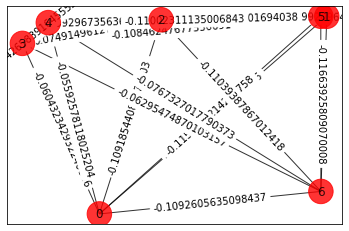

In [95]:
n=len(cities) # Number of cities
G=nx.Graph()
G.add_nodes_from(np.arange(0,n,1))

elist=[]

#the weight on each edge is the DIFFERENCE
#between the total supply impact and the total covid impact
#since we are seeking a miimum,
#supply chain impact is "positive" i.e. "bad"
#and covid impact is "negative" i.e. "good"

for i in range(len(cities)):
    for j in range(i+1,len(cities)):
        elist.append((i,j,\
                      total_supply_impact(cities[i],cities[j])\
                      -total_covid_impact(cities[i],cities[j])))
        

elist=tuple(elist)


G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [96]:
# Computing the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp['weight']
print(w)

[[ 0.         -0.05135546 -0.10918544 -0.06043234 -0.05592578 -0.11512382
  -0.10926056]
 [-0.05135546  0.          0.08772711  0.15266134  0.14950967 -0.10439921
  -0.06274753]
 [-0.10918544  0.08772711  0.          0.07491496  0.09296736 -0.11839489
  -0.11039388]
 [-0.06043234  0.15266134  0.07491496  0.          0.22426584 -0.10846248
  -0.06295475]
 [-0.05592578  0.14950967  0.09296736  0.22426584  0.         -0.11002311
  -0.0767327 ]
 [-0.11512382 -0.10439921 -0.11839489 -0.10846248 -0.11002311  0.
  -0.11663926]
 [-0.10926056 -0.06274753 -0.11039388 -0.06295475 -0.0767327  -0.11663926
   0.        ]]


In [97]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-cut

Maximize
 obj: - 0.501283414053 x_0 + 0.171395920744 x_1 - 0.082364785144 x_2
      + 0.219992575964 x_3 + 0.224061273521 x_4 - 0.673042767455 x_5
      - 0.538728679339 x_6 + [ 0.205421856604 x_0*x_1 + 0.436741763411 x_0*x_2
      + 0.241729371729 x_0*x_3 + 0.223703124721 x_0*x_4 + 0.460495285708 x_0*x_5
      + 0.437042254039 x_0*x_6 - 0.350908427601 x_1*x_2 - 0.610645375719 x_1*x_3
      - 0.598038689188 x_1*x_4 + 0.417596838571 x_1*x_5 + 0.250990114355 x_1*x_6
      - 0.299659845114 x_2*x_3 - 0.371869425476 x_2*x_4 + 0.473579560678 x_2*x_5
      + 0.441575514680 x_2*x_6 - 0.897063356658 x_3*x_4 + 0.433849907102 x_3*x_5
      + 0.251818994804 x_3*x_6 + 0.440092445400 x_4*x_5 + 0.306930807116 x_4*x_6
      + 0.466557032363 x_5*x_6 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1
 0 <= x_6 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5 x_6
En

In [98]:
qubitOp, offset = qp.to_ising()
print('Offset:', offset)
print('Ising Hamiltonian:')
print(str(qubitOp))

Offset: 0.29499246894070774
Ising Hamiltonian:
-0.05831962904535004 * ZZIIIII
- 0.03836635088951865 * ZIZIIII
- 0.05501155567503421 * IZZIIII
- 0.031477374350515785 * ZIIZIII
- 0.054231238387753455 * IZIZIII
+ 0.11213291958227761 * IIZZIII
- 0.05519693933506209 * ZIIIZII
- 0.0591974450847019 * IZIIZII
+ 0.046483678184451094 * IIZIZII
+ 0.037457480639307206 * IIIZZII
- 0.031373764294330614 * ZIIIIZI
- 0.05219960482138156 * IZIIIZI
+ 0.07475483614843875 * IIZIIZI
+ 0.07633067196482357 * IIIZIZI
+ 0.04386355345017895 * IIIIZZI
- 0.05463028175492185 * ZIIIIIZ
- 0.0575619107134879 * IZIIIIZ
- 0.02796289059012602 * IIZIIIZ
- 0.030216171466120323 * IIIZIIZ
- 0.054592720426392016 * IIIIZIZ
- 0.025677732075488513 * IIIIIZZ


In [99]:
#Running it on quantum computer
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend('aer_simulator_statevector')
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

energy: -0.5118589981541527
time: 13.910153150558472
max-cut objective: -0.21686652921344496
solution: [0. 0. 0. 1. 0. 0. 0.]
solution objective: 0.21999257596403765


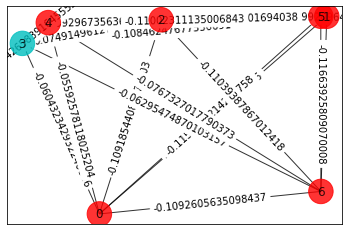

In [100]:
# construct VQE
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

# run VQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
x = max_cut.sample_most_likely(result.eigenstate)
print('energy:', result.eigenvalue.real)
print('time:', result.optimizer_time)
print('max-cut objective:', result.eigenvalue.real + offset)
print('solution:', x)
print('solution objective:', qp.objective.evaluate(x))

# plot results
colors = ['r' if x[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)

In [101]:
from qiskit import IBMQ
#Constructing VQE 

IBMQ.save_account(my_account_key,overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')


print(provider.backends())
backend = provider.get_backend('ibmq_qasm_simulator')


ibmqfactory.load_account:WARNING:2021-08-31 03:15:48,713: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_manila') fro

In [102]:
#program = provider.runtime.program('vqe')
#print(program)
#qiskit runtime
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)
    
    
measurement_error_mitigation = True

In [103]:
from qiskit_nature.runtime import VQEProgram

# in this first release, the optimizer must be specified as dictionary
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=5, entanglement='linear')

runtime_vqe = VQEProgram( ry, 
                         optimizer=spsa,
                         provider=provider,
                         backend=backend,
                         shots=8192,
                         measurement_error_mitigation=measurement_error_mitigation,
                         callback=callback )


energy: -0.5144108991933553
time: 564.1751806735992
max-cut objective: -0.2194184302526475
solution: [0 1 1 1 0 0 0]
solution objective: -0.3215831126531576


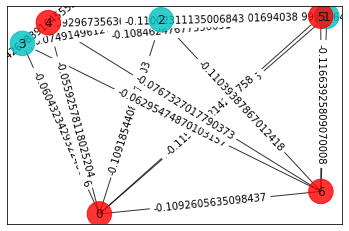

In [104]:
qubitOp, offset = qp.to_ising()

#run VQE runtime
runtime_result = runtime_vqe.compute_minimum_eigenvalue(qubitOp)
#print results
x = max_cut.sample_most_likely(runtime_result.eigenstate)
print('energy:', runtime_result.eigenvalue.real)
print('time:', runtime_result.optimizer_time)
print('max-cut objective:', runtime_result.eigenvalue.real + offset)
print('solution:', x)
print('solution objective:', qp.objective.evaluate(x))

# plot results
colors = ['r' if x[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)


In [ ]:
# create minimum eigen optimizer based on VQE runtime
vqe_optimizer =  MinimumEigenOptimizer(VQE(quantum_instance = backend))

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)

colors = ['r' if result.x[i] == 0 else 'c' for i in range(n)]
draw_graph(G, colors, pos)